<br><br><br>
# Lab 1. Euler Beam (Solid Mechanics)

## 1.1. Problem Setup

- We will solve a Euler beam problem:


<br>
<center>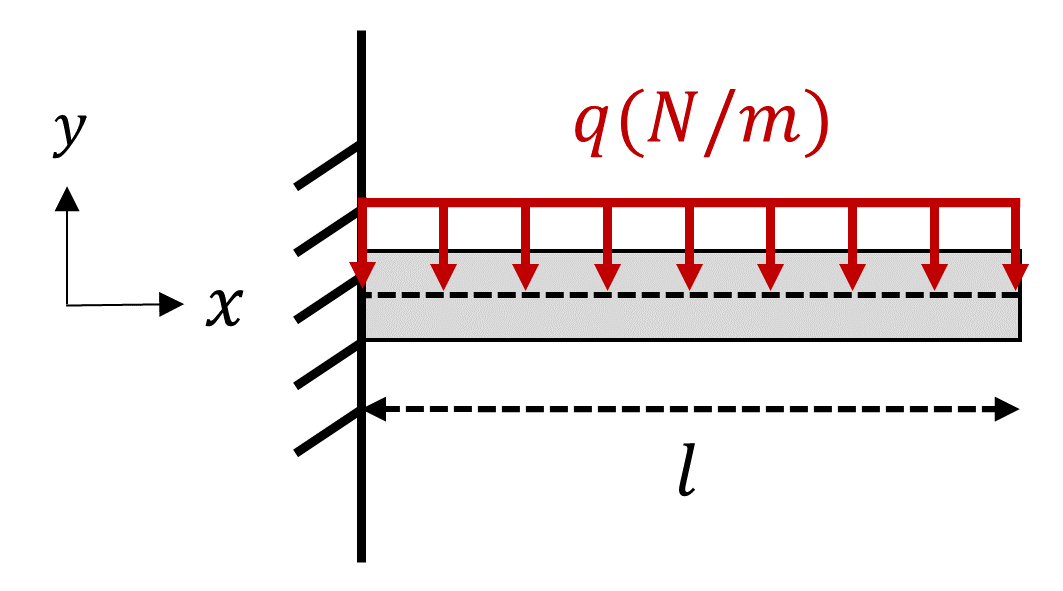</center>
<br>




- Problem properties

$$E = 1 \operatorname{pa}, \quad I = 1 \operatorname{kg\cdot m^2}, \quad q = 1 \operatorname{N/m}, \quad l = 1 \operatorname{m}$$
<br>

- Partial differential equations & boundary conditions

<br>
$${\partial^4 y \over \partial x^4} + q = 0,  \qquad \text{where} \quad x \in [0,1]$$
<br>

- One Dirichlet boundary condition on the left boundary:

<br>
$$y(0) = 0$$
<br>

- One Neumann boundary condition on the left boundary:

<br>
$$y'(0) = 0$$
<br>

- Two boundary conditions on the right boundary:

<br>
$$y''(1) = 0, \quad y'''(1) = 0$$
<br>

- The exact solution is

<br>
$$y(x) = -{1 \over 24}x^4 + {1 \over 6}x^3 - {1 \over 4}x^2$$
<br>

- Make a neural network and loss functions like below :


<br><br>
<center>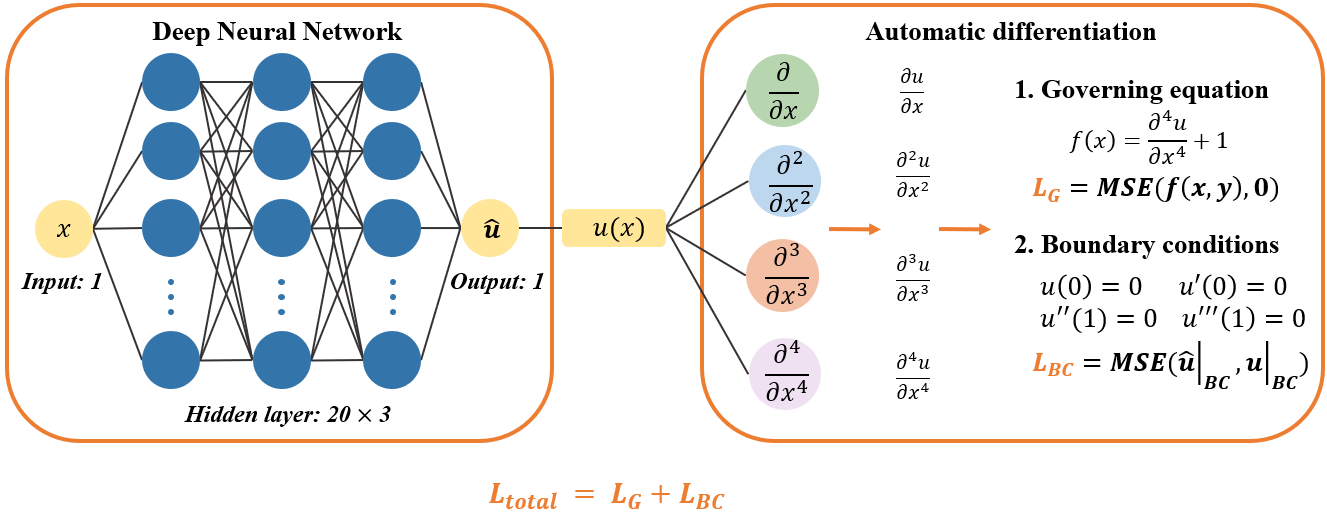</center>
<br>

## 1.2. Solve the Euler Beam problem

### 1.2.1. Import Library

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

### 1.2.2. Define Parameters

In [ ]:
E = 1
I = 1
q = 1
l = 1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### 1.2.3. Define Collocation Points

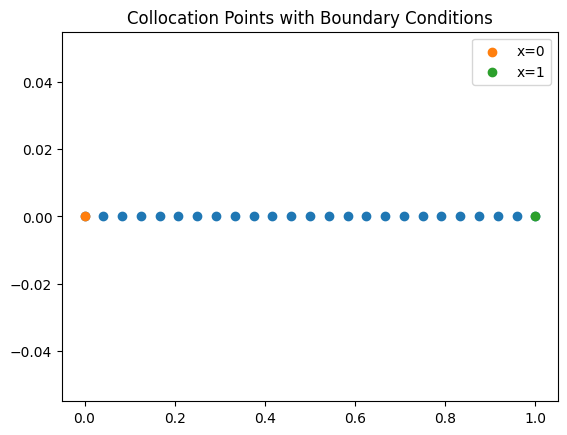

In [ ]:
x = np.linspace(0, l, 25)
y = np.zeros_like(x)
x0 = x[0]  # Boundary condition when x = 0
x1 = x[-1]  # Boundary condition when x = 1
plt.scatter(x, y)
plt.scatter(x0, 0, label='x=0')
plt.scatter(x1, 0, label='x=1')
plt.legend()
plt.title('Collocation Points with Boundary Conditions')
plt.show()

### 1.2.4. Define Network and Hyper-parameters

In [ ]:
import torch.nn as nn
from torch.nn import Linear, Tanh

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            Linear(1, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 1),
            Tanh(),
        )

    def forward(self, x):
        return self.net(x)

model = PINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

### 1.2.5. Define PDE System

$${\partial^4 y \over \partial x^4} + q = 0,  \qquad \text{where} \quad x \in [0,1]$$
<br>

In [ ]:
def derivative(f, t):
    return torch.autograd.grad(f, t, grad_outputs = torch.ones_like(f), create_graph = True)[0]

def PDE(model, x):
    u = model(x)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    u_xxx = derivative(u_xx, x)
    u_xxxx = derivative(u_xxx, x)

    pde = u_xxxx + q
    return pde

### 1.2.6. Define Boundary Condition


- One Dirichlet boundary condition on the left boundary:

<br>
$$y(0) = 0$$
<br>

- One Neumann boundary condition on the left boundary:

<br>
$$y'(0) = 0$$
<br>

- Two boundary conditions on the right boundary:

<br>
$$y''(1) = 0, \quad y'''(1) = 0$$
<br>

In [ ]:
def BC_left(model, x_0):
    # x = 0
    u_0 = model(x_0)
    bc1 = u_0

    u_x_0 = derivative(u_0, x_0)
    bc2 = u_x_0
    return bc1, bc2

def BC_right(model, x_f):
    # x = 1
    u_f = model(x_f)
    u_x_f = derivative(u_f, x_f)
    u_xx_f = derivative(u_x_f, x_f)
    bc3 = u_xx_f

    u_xxx_f = derivative(u_xx_f, x_f)
    bc4 = u_xxx_f
    return bc3, bc4

### 1.2.7. Define Exact Solution

In [ ]:
def exact_solution(x):
    return -(x ** 4) / 24 + x ** 3 / 6 - x ** 2 / 4

### 1.2.8. Train & Prediction

In [ ]:
def require_grad(x, device=device):
    return torch.tensor(x, device=device, dtype=torch.float32, requires_grad=True)

epochs = 3001

x = require_grad(x.reshape(-1, 1))
x0 = require_grad(x0.reshape(-1, 1))
x1 = require_grad(x1.reshape(-1, 1))

for epoch in range(epochs):
    pde_term = PDE(model, x)
    bc1, bc2 = BC_left(model, x0)
    bc3, bc4 = BC_right(model, x1)

    loss_pde = loss_fn(pde_term, torch.zeros_like(pde_term).to(device))
    loss_bc1 = loss_fn(bc1, torch.zeros_like(bc1).to(device))
    loss_bc2 = loss_fn(bc2, torch.zeros_like(bc2).to(device))
    loss_bc3 = loss_fn(bc3, torch.zeros_like(bc3).to(device))
    loss_bc4 = loss_fn(bc4, torch.zeros_like(bc4).to(device))
    loss_bc = loss_bc1 + loss_bc2 + loss_bc3 + loss_bc4

    loss = loss_pde + loss_bc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f'Epoch {epoch}, Loss: {loss}')

print('Training Finsh')

Epoch 0, Loss: 1.060953140258789
Epoch 1000, Loss: 6.542677147081122e-05
Epoch 2000, Loss: 0.0001579928066348657
Epoch 3000, Loss: 1.8515955162001774e-05
Training Finsh


### 1.2.6. Result

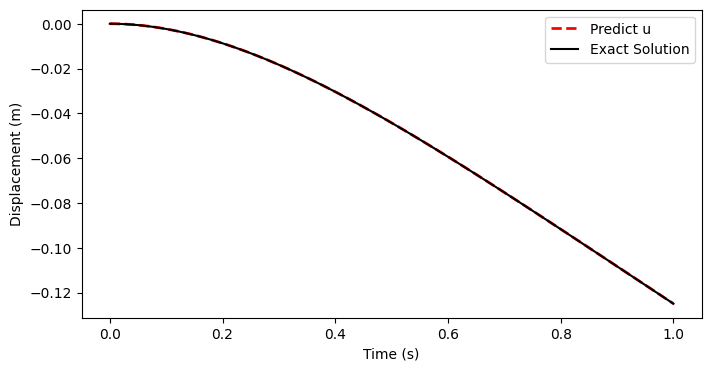

In [ ]:
x_ = np.linspace(0, l, 100)
x_ = torch.tensor(x_.reshape(-1, 1), dtype=torch.float32)
with torch.no_grad():
    model.cpu()
    model.eval()
    u_ = model(x_)

plt.figure(figsize = (8, 4))
plt.plot(x_, u_.detach().numpy(), c =  'r', label = 'Predict u', linestyle = 'dashed', linewidth = 2)
plt.plot(x_, exact_solution(x_), c =  'k', label = 'Exact Solution')
plt.legend(fontsize = 10)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel('Time (s)', fontsize = 10)
plt.ylabel('Displacement (m)', fontsize = 10)
plt.show()



---



<br><br><br>
# Lab 2. Pendulum (Rigid Body ODE)

## 2.1. Problem Setup

- We will solve a pendulum problem:

<br>

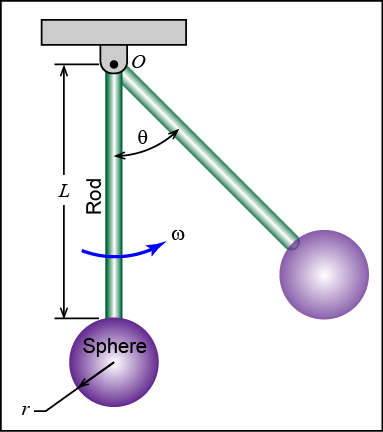

<br>



- Problem properties

$$
g = 9.81\;\mathrm{m/s^2}, \quad
L = 0.025\;\mathrm{m}, \quad
\theta_0 = \frac{\pi}{4}\;\mathrm{rad}, \quad
\dot{\theta}_0 = 0
$$
<br>

- Ordinary differential equation & initial conditions

<br>
$$
\frac{d^2\theta}{dt^2} + \frac{g}{L}\sin(\theta) = 0,
\qquad \text{where} \quad t \in [0,\,1]
$$
<br>

- Initial condition for angular displacement:

<br>
$$
\theta(0) = \theta_0
$$
<br>

- Initial condition for angular velocity:

<br>
$$
\frac{d\theta}{dt}(0) = \dot{\theta}_0
$$
<br>

- Reference (exact) solution

<br>
The nonlinear pendulum does not admit a simple closed-form solution.
Therefore, the reference solution is defined as the numerical solution
of the governing ODE obtained using a high-accuracy ODE solver (e.g. `odeint`).

For comparison, the small-angle approximation (\(|\theta|\ll 1\)) yields

$$
\frac{d^2\theta}{dt^2} + \frac{g}{L}\theta = 0
$$

with the analytical solution

$$
\theta_{\text{lin}}(t)
=
\theta_0 \cos\!\left(\sqrt{\frac{g}{L}}\,t\right).
$$
<br>

- Make a neural network and loss functions like below :

<br><br>

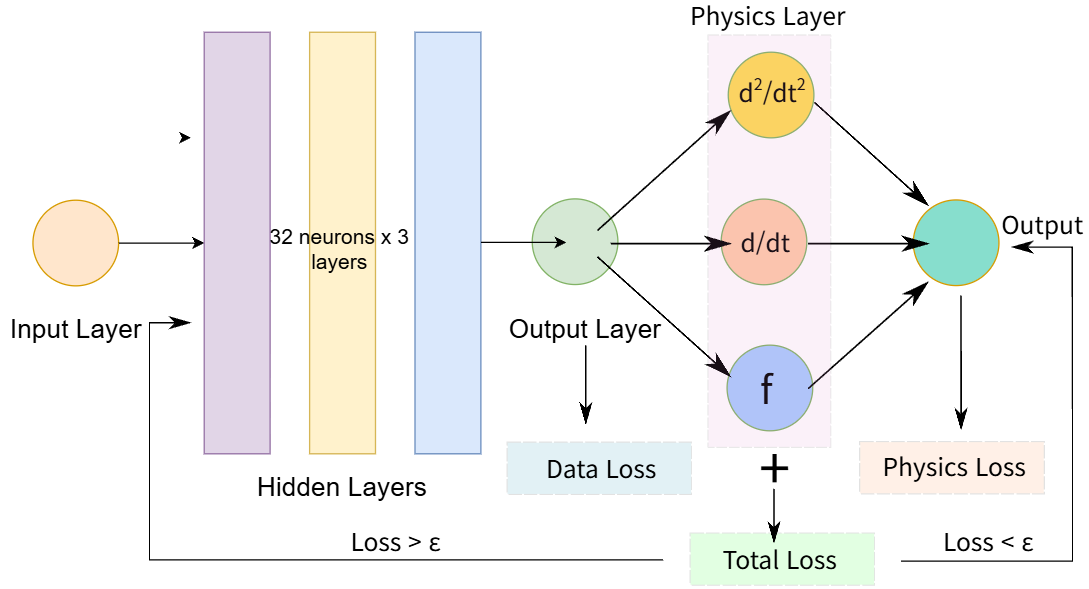

<br>


## 2.2. Solve the Pendulum problem

### 2.2.1. Import Library

In [34]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.integrate import odeint

### 2.2.2. Define Parameters

In [35]:
# Parameters
L = 0.025  # length of pendulum (m)
g = 9.81   # gravity (m/s^2)

w = np.sqrt(g / L)
k = w**2              # k = g/L
end_time = 1.0

# Initial state used to generate "reference" (odeint) and sparse training data
theta0 = np.pi / 4
omega0 = 0.0
initial_state = [theta0, omega0]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### 2.2.3. Define Collocation Points (time domain) & Training data

In [36]:
# Full time domain (for plotting / evaluation)
t = np.linspace(0, end_time, 500)
x = torch.tensor(t, dtype=torch.float32).view(-1, 1)  # (500,1)

# Sparse training data locations (N=10)
x_data = x[0:200:20]  # includes t=0
print("x:", x.shape, "x_data:", x_data.shape)

# Physics collocation points (M=30)
x_physics = torch.linspace(0, end_time, 30).view(-1, 1).requires_grad_(True)
print("x_physics:", x_physics.shape)

x: torch.Size([500, 1]) x_data: torch.Size([10, 1])
x_physics: torch.Size([30, 1])


###2.2.4. Define Exact Solution

In [37]:
# Nonlinear pendulum ODE (reference)
def simple_pendulum_eqn(state, t, L, g):
    theta, theta_dot = state
    theta_ddot = -(g / L) * np.sin(theta)
    return [theta_dot, theta_ddot]

# Reference (odeint) solution
states = odeint(simple_pendulum_eqn, initial_state, t, args=(L, g))
y = torch.tensor(states[:, 0], dtype=torch.float32).view(-1, 1)  # theta(t)
y_data = y[0:200:20]  # sparse labels (same slicing)

print("y:", y.shape, "y_data:", y_data.shape)

# Small-angle approximation
def small_angle_solution(w, x_torch):
    return theta0 * torch.cos(torch.tensor(w, dtype=torch.float32) * x_torch)

y: torch.Size([500, 1]) y_data: torch.Size([10, 1])


###2.2.5. Make Reference Data & Plot

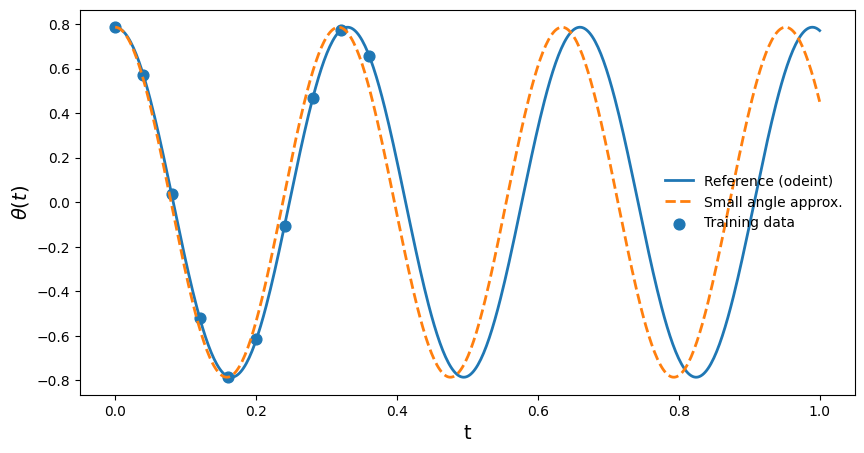

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(x.numpy(), y.numpy(), label='Reference (odeint)', linewidth=2)
plt.plot(x.numpy(), small_angle_solution(w, x).numpy(), '--', label='Small angle approx.', linewidth=2)
plt.scatter(x_data.numpy(), y_data.numpy(), s=60, label='Training data')
plt.xlabel('t', fontsize=14)
plt.ylabel(r'$\theta(t)$', fontsize=14)
plt.legend(frameon=False)
plt.show()


### 2.2.6. Define Network and Hyper-parameters

In [39]:
from torch.nn import Linear, Tanh

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            Linear(1, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 32),
            Tanh(),
            Linear(32, 1),
        )

    def forward(self, t):
        return self.net(t)

torch.manual_seed(123)          # same seed style
model = PINN()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### 2.2.7. Define ODE System

$$
\frac{d^2\theta}{dt^2} + \frac{g}{L}\sin(\theta) = 0,
\qquad \text{where} \quad t \in [0,\,1]
$$
<br>

In [40]:
def derivative(f, t):
    return torch.autograd.grad(
        f, t,
        grad_outputs=torch.ones_like(f),
        create_graph=True
    )[0]

def ODE_residual(model, t):
    # theta(t)
    theta = model(t)

    # dtheta/dt
    theta_t = derivative(theta, t)

    # d2theta/dt2
    theta_tt = derivative(theta_t, t)

    # residual: theta_tt + k*sin(theta) = 0
    return theta_tt + k * torch.sin(theta)

### 2.2.9. Train & Prediction

In [41]:
epochs = 20000

files_loss = []
for i in range(epochs):
    optimizer.zero_grad()

    # 1) Data loss (MSE on sparse training data)
    yh_data = model(x_data)
    loss_data = torch.mean((yh_data - y_data) ** 2)

    # 2) Physics loss (MSE of residual on collocation points)
    yh_phys = model(x_physics)
    d1 = torch.autograd.grad(yh_phys, x_physics, torch.ones_like(yh_phys), create_graph=True)[0]
    d2 = torch.autograd.grad(d1, x_physics, torch.ones_like(d1), create_graph=True)[0]
    physics = d2 + k * torch.sin(yh_phys)
    loss_phys = (1e-4) * torch.mean(physics ** 2)   # IMPORTANT: blog style

    # Total loss
    loss = loss_data + loss_phys
    loss.backward()
    optimizer.step()

    if (i + 1) % 2000 == 0:
        print(f"Step {i+1:5d} | Total: {loss.item():.6e} | Data: {loss_data.item():.6e} | Phys: {loss_phys.item():.6e}")

Step  2000 | Total: 3.446043e-01 | Data: 3.431765e-01 | Phys: 1.427766e-03
Step  4000 | Total: 2.209326e-01 | Data: 1.585578e-01 | Phys: 6.237479e-02
Step  6000 | Total: 6.400806e-02 | Data: 1.367973e-02 | Phys: 5.032834e-02
Step  8000 | Total: 5.591112e-02 | Data: 9.429319e-03 | Phys: 4.648180e-02
Step 10000 | Total: 4.537801e-02 | Data: 6.942755e-03 | Phys: 3.843525e-02
Step 12000 | Total: 1.506551e-04 | Data: 2.119032e-05 | Phys: 1.294648e-04
Step 14000 | Total: 1.148004e-05 | Data: 3.029009e-06 | Phys: 8.451034e-06
Step 16000 | Total: 5.000950e-06 | Data: 9.892408e-07 | Phys: 4.011710e-06
Step 18000 | Total: 3.162982e-06 | Data: 6.485185e-07 | Phys: 2.514464e-06
Step 20000 | Total: 2.438372e-06 | Data: 5.495846e-07 | Phys: 1.888787e-06


### 2.2.6. Result

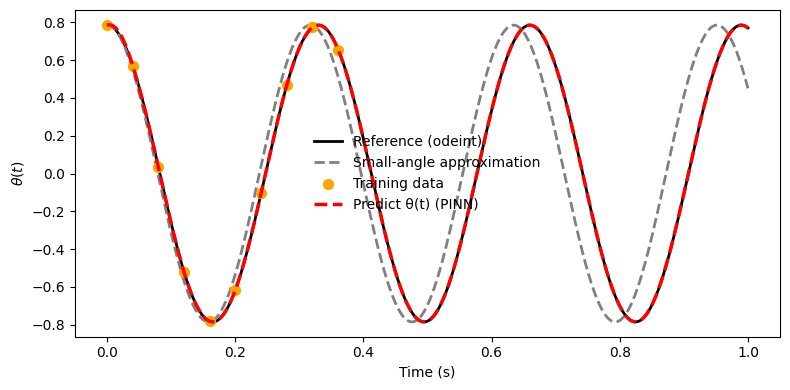

In [45]:
# Small-angle approximation (for plotting)
y_small = small_angle_solution(w, x)

plt.figure(figsize=(8, 4))

# 1) Reference solution (odeint)
plt.plot(
    x.numpy(), y.numpy(),
    color='black', linewidth=2,
    label='Reference (odeint)', zorder=1
)

# 2) Small-angle approximation
plt.plot(
    x.numpy(), y_small.numpy(),
    color='gray', linestyle='--', linewidth=2,
    label='Small-angle approximation', zorder=2
)

# 3) Training data
plt.scatter(
    x_data.numpy(), y_data.numpy(),
    s=50, color='orange',
    label='Training data', zorder=3
)

# 4) PINN prediction (맨 위)
plt.plot(
    x.numpy(), y_pred.numpy(),
    color='red', linestyle='--', linewidth=2.5,
    label='Predict θ(t) (PINN)', zorder=4
)

plt.xlabel('Time (s)')
plt.ylabel(r'$\theta(t)$')
plt.legend(frameon=False)
plt.tight_layout()
plt.show()




---



<br><br><br>
# Lab 3. Navier-Stokes Equations (Fluid Mechanics)

## 3.1. Problem Setup

- We will solve 2D Navier-Stokes Equations to find velocity profile in infinite parallel plates flow
    - Any fluid flowing in plates had to enter at some location. The region of flow near where the fluid enters the plates is termed the entrance region and is illustrated in below figure
    - The fluid typically enters the plates with a nearly uniform velocity profile
    - As the fluid moves through the plates, viscous effects cause it to stick to the plates wall (no-slip boundary condition)
    - Thus, a boundary layer is produced along the plates wall such that the initial velocity profile changes with distance along the plates,  x


<br>

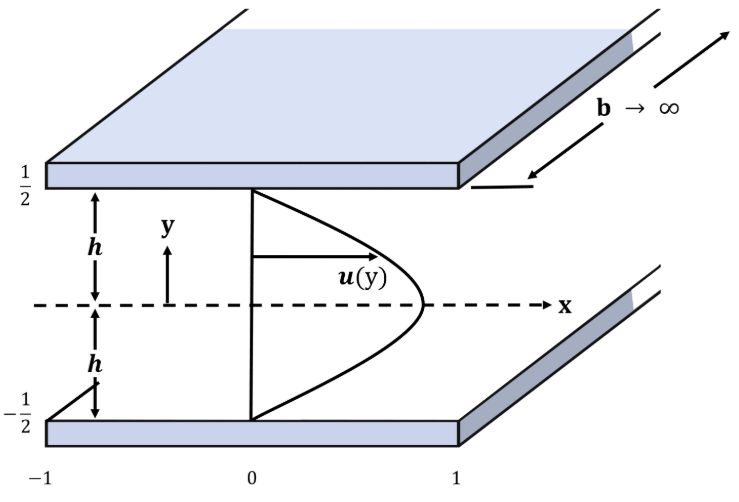

<br>


<br><br>

Problem properties

<br> $$ \rho = 1 \operatorname{kg/m^3}, \quad \mu = 1 \operatorname{N \cdot s/m^2}, \quad D = 2h = 1 \operatorname{m}, \quad L = 2 \operatorname{m}, \quad u_{in} = 1 \operatorname{m/s}, \quad \nu = \frac{\mu}{\rho} $$ <br>

Hydraulic diameter is

<br> $$ D_h = \lim_{b \to \infty} \frac{4(2bh)}{2b + 4h} = 4h = 2 \operatorname{m} $$ <br>

So, the Reynolds number of this system is

<br> $$ Re = \frac{\rho u_{in} D_h}{\mu} = 2 $$ <br>

2D Navier-Stokes Equations & boundary conditions (for steady state)

<br> $$ u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{1}{\rho} \frac{\partial p}{\partial x} - \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) = 0 $$

<br> $$ u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{1}{\rho} \frac{\partial p}{\partial y} - \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) = 0 $$

<br> $$ \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 $$ <br>

Two Dirichlet boundary conditions on the plate boundary (no-slip condition)

<br> $$ u(x,y) = 0, \quad v(x,y) = 0 \qquad \text{at} \quad y = \frac{D}{2} \ \text{or} \ y = -\frac{D}{2} $$ <br>

Two Dirichlet boundary conditions at the inlet boundary

<br> $$ u(-1,y) = u_{in}, \quad v(-1,y) = 0 $$ <br>

Two Dirichlet boundary conditions at the outlet boundary

<br> $$ p(1,y) = 0, \quad v(1,y) = 0 $$ <br>

<br>

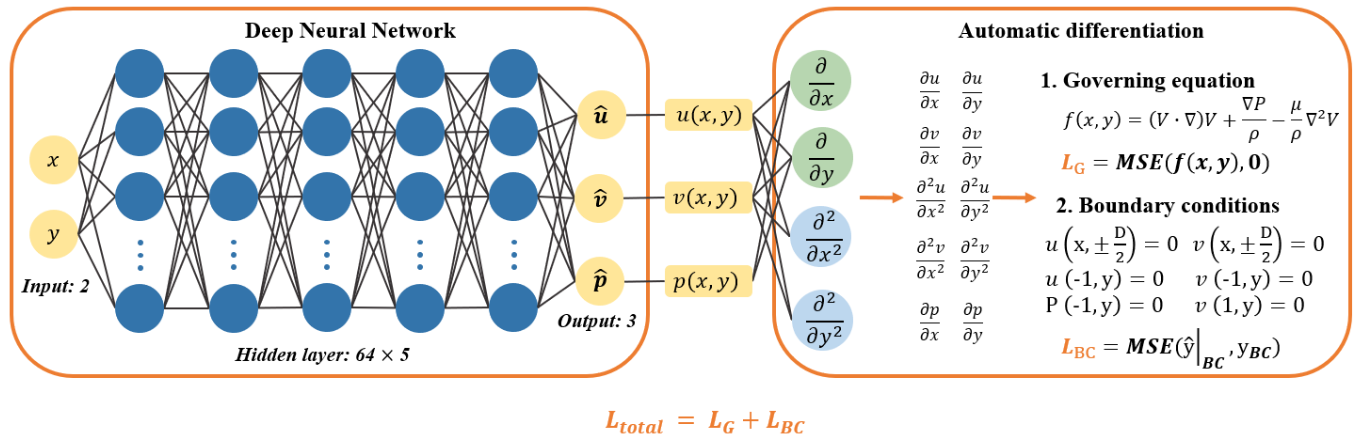

<br>

## 3.2.CFD Solution
- CFD solution of this problem is illustrated in below figures
 - Velocity u and velocity v, and pressure p, respectively
    
    
- Solve this problem using PINN and then compare with CFD solutions

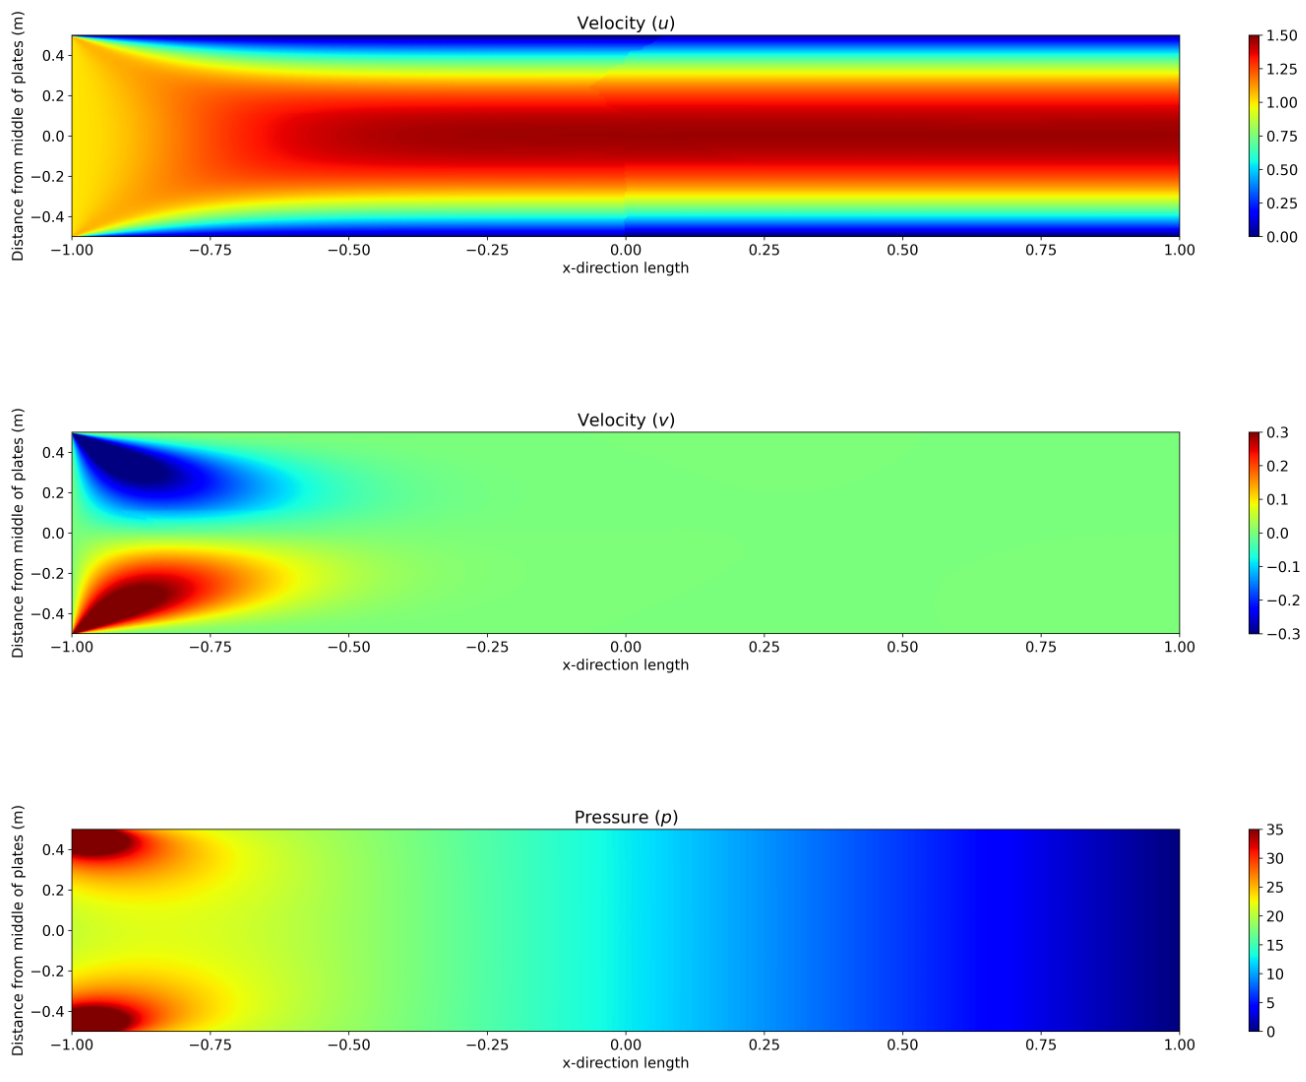

<br>

## 3.3. PINN as PDE Solver

### 3.3.1. Import Libarary and Define Parameters

In [50]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 13.6 MB/s eta 0:00:00


In [51]:
import deepxde as dde
import numpy as np

# Properties
rho = 1
mu = 1
u_in = 1
D = 1
L = 2

No backend selected.
Finding available backend...
Found tensorflow
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



### 3.3.2. Define PDE with Boundary & Initial Conditions

In [52]:
def boundary_wall(X, on_boundary):
    on_wall = np.logical_and(np.logical_or(np.isclose(X[1], -D/2), np.isclose(X[1], D/2)), on_boundary)
    return on_wall

def boundary_inlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], -L/2)

def boundary_outlet(X, on_boundary):
    return on_boundary and np.isclose(X[0], L/2)

In [53]:
def pde(X, Y):
    du_x = dde.grad.jacobian(Y, X, i = 0, j = 0)
    du_y = dde.grad.jacobian(Y, X, i = 0, j = 1)
    dv_x = dde.grad.jacobian(Y, X, i = 1, j = 0)
    dv_y = dde.grad.jacobian(Y, X, i = 1, j = 1)
    dp_x = dde.grad.jacobian(Y, X, i = 2, j = 0)
    dp_y = dde.grad.jacobian(Y, X, i = 2, j = 1)
    du_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 0)
    du_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 0)
    dv_xx = dde.grad.hessian(Y, X, i = 0, j = 0, component = 1)
    dv_yy = dde.grad.hessian(Y, X, i = 1, j = 1, component = 1)

    pde_u = Y[:,0:1]*du_x + Y[:,1:2]*du_y + 1/rho * dp_x - (mu/rho)*(du_xx + du_yy)
    pde_v = Y[:,0:1]*dv_x + Y[:,1:2]*dv_y + 1/rho * dp_y - (mu/rho)*(dv_xx + dv_yy)
    pde_cont = du_x + dv_y

    return [pde_u, pde_v, pde_cont]

### 3.3.3. Define Geometry, Implement Boundary Condition

In [54]:
geom = dde.geometry.Rectangle(xmin=[-L/2, -D/2], xmax=[L/2, D/2])

bc_wall_u = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 0)
bc_wall_v = dde.DirichletBC(geom, lambda X: 0., boundary_wall, component = 1)

bc_inlet_u = dde.DirichletBC(geom, lambda X: u_in, boundary_inlet, component = 0)
bc_inlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_inlet, component = 1)

bc_outlet_p = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 2)
bc_outlet_v = dde.DirichletBC(geom, lambda X: 0., boundary_outlet, component = 1)

In [55]:
data = dde.data.PDE(geom,
                    pde,
                    [bc_wall_u, bc_wall_v, bc_inlet_u, bc_inlet_v, bc_outlet_p, bc_outlet_v],
                    num_domain = 3000,
                    num_boundary = 500,
                    num_test = 1000,
                    train_distribution = 'LHS' )

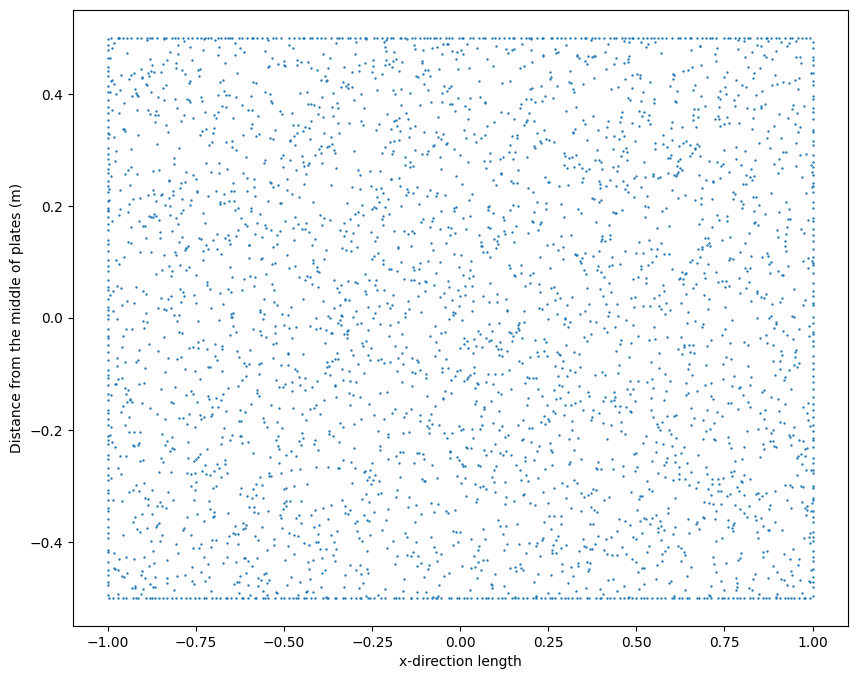

In [56]:
plt.figure(figsize = (10,8))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.5)
plt.xlabel('x-direction length')
plt.ylabel('Distance from the middle of plates (m)')
plt.show()

### 3.3.4. Define Network and Hyper-parameters

In [57]:
layer_size = [2] + [64] * 5 + [3]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr = 1e-3)

Compiling model...
'compile' took 0.067604 s



### 3.3.5 Train (Adam Optimizer)

Training model...



Cause: could not parse the source code of <function <lambda> at 0x7db79d32dee0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32dee0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32e2a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32e2a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32e660>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32e660>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32ea20>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32ea20>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32ede0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32ede0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32f1a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7db79d32f1a0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.50e-01, 4.44e-01, 4.42e-02, 1.38e-02, 8.52e-04, 1.35e+00, 7.43e-04, 1.70e-01, 7.45e-04]    [1.53e-01, 4.56e-01, 4.58e-02, 1.38e-02, 8.52e-04, 1.35e+00, 7.43e-04, 1.70e-01, 7.45e-04]    []  
1000      [2.41e-02, 6.37e-04, 7.64e-03, 3.83e-02, 1.52e-02, 4.03e-02, 3.80e-03, 5.88e-03, 5.28e-05]   

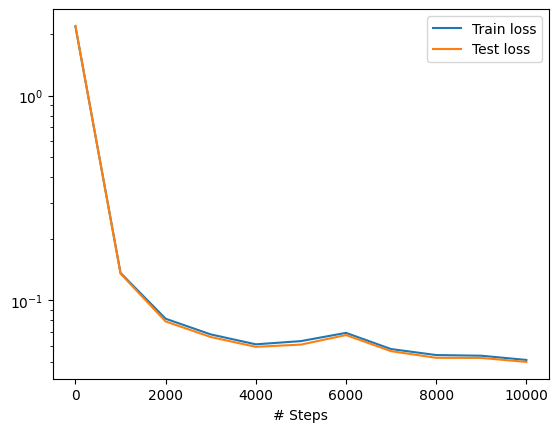

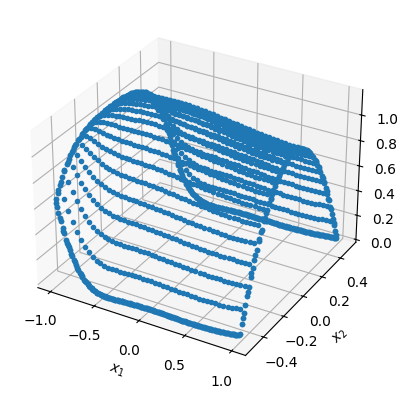

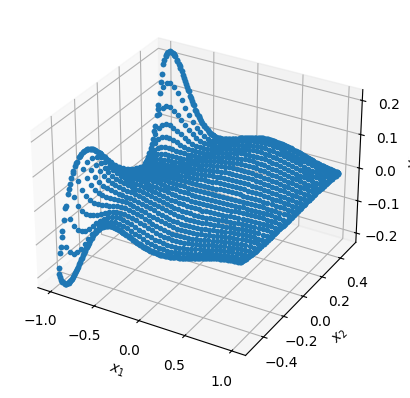

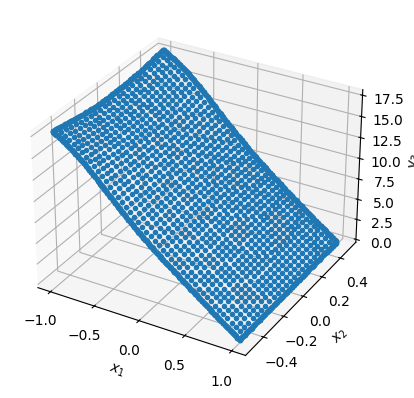

In [58]:
losshistory, train_state = model.train(epochs = 10000)
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

### 3.3.6. Plot Results (Adam Optimizer)

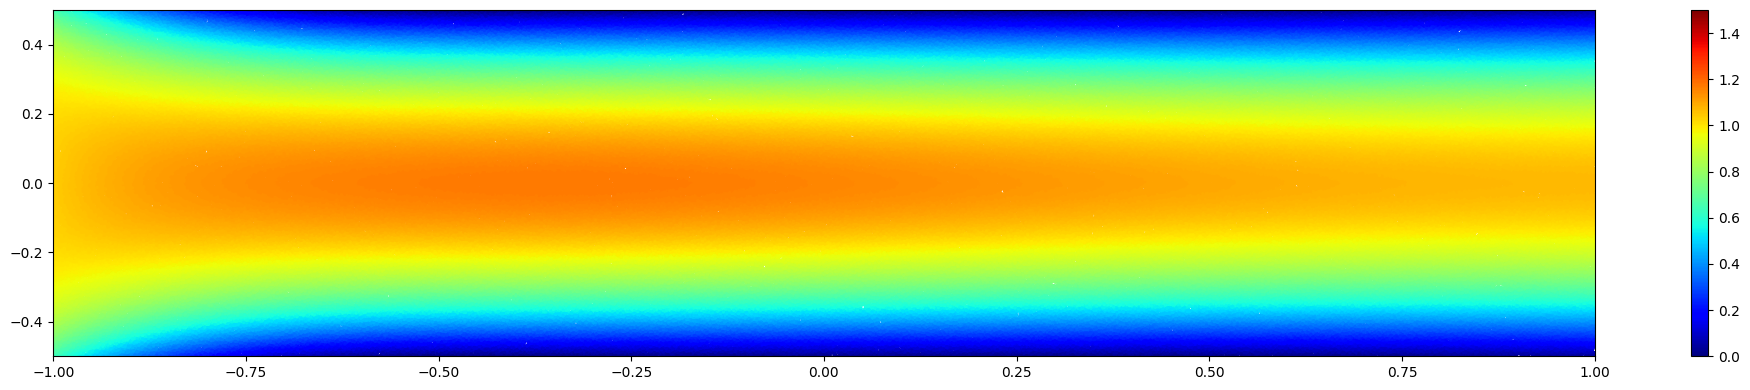

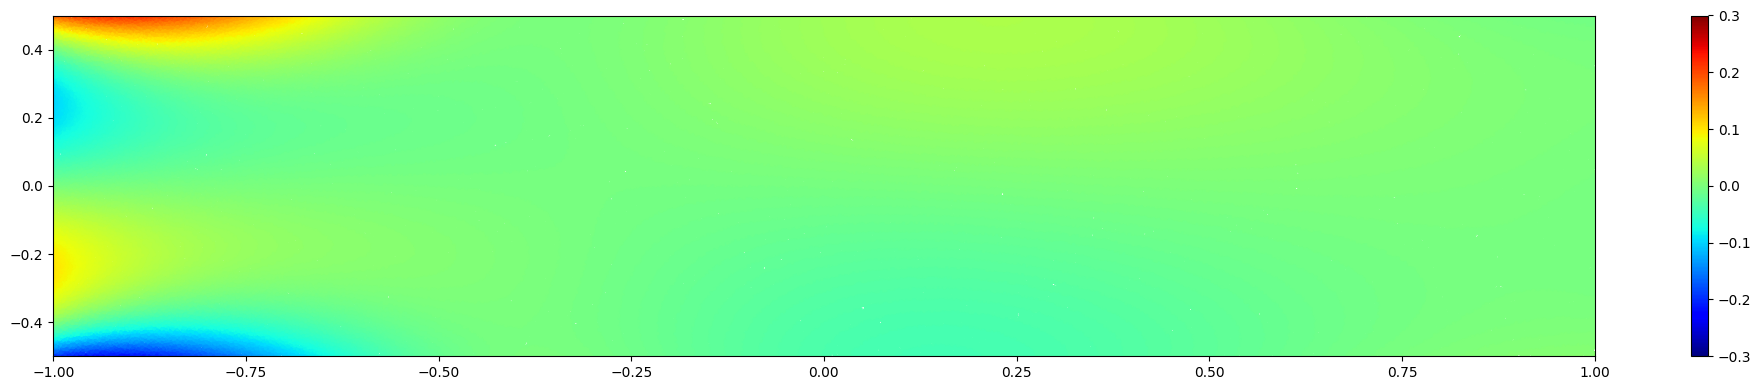

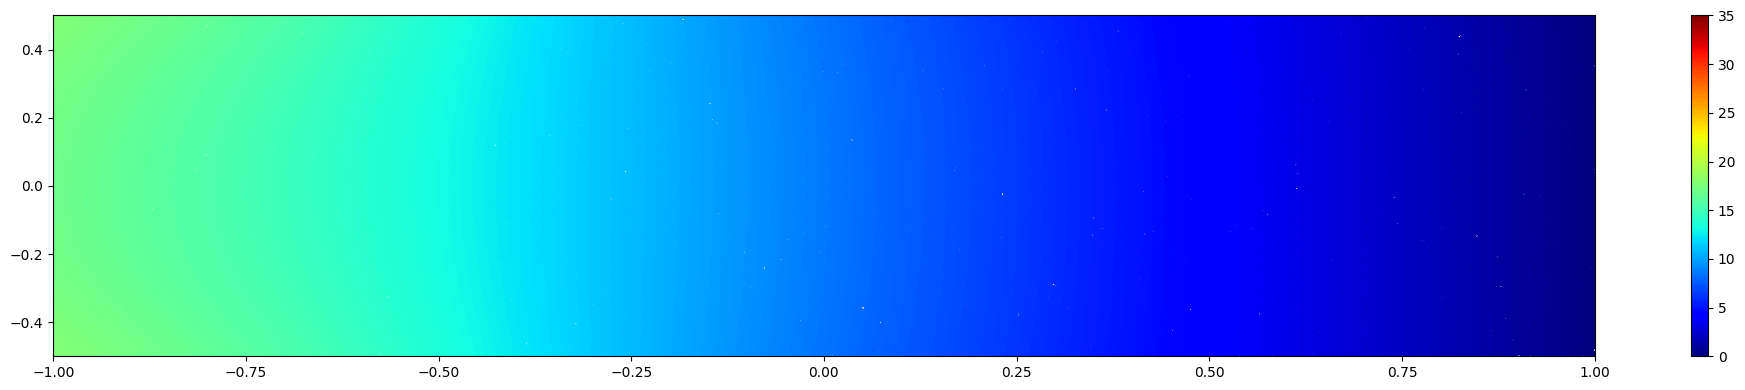

In [59]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

### 3.3.7. Train More (L-BFGS Optimizer)

Compiling model...
'compile' took 0.002988 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
10000     [1.66e-03, 4.77e-04, 1.96e-03, 1.88e-02, 6.13e-03, 1.54e-02, 6.33e-03, 3.15e-04, 8.96e-06]    [1.59e-03, 3.82e-04, 9.98e-04, 1.88e-02, 6.13e-03, 1.54e-02, 6.33e-03, 3.15e-04, 8.96e-06]    []  
13000     [4.29e-04, 4.45e-04, 4.61e-04, 7.15e-03, 1.24e-03, 4.11e-03, 1.91e-03, 1.22e-05, 5.66e-06]    [3.81e-04, 3.13e-04, 2.12e-04, 7.15e-03, 1.24e-03, 4.11e-03, 1.91e-03, 1.22e-05, 5.66e-06]    []  

Best model at step 13000:
  train loss: 1.58e-02
  test loss: 1.53e-02
  test metric: []

'train' took 1065.675205 s



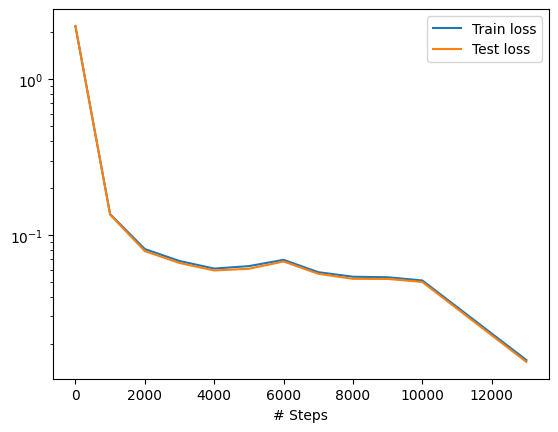

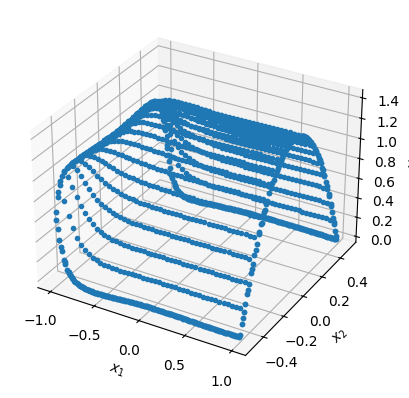

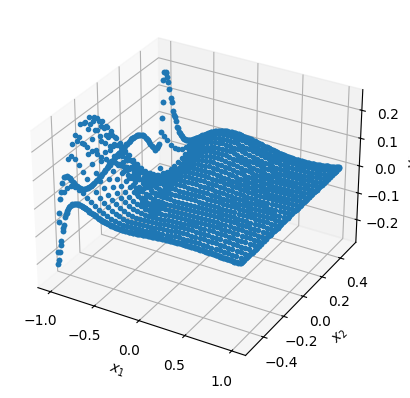

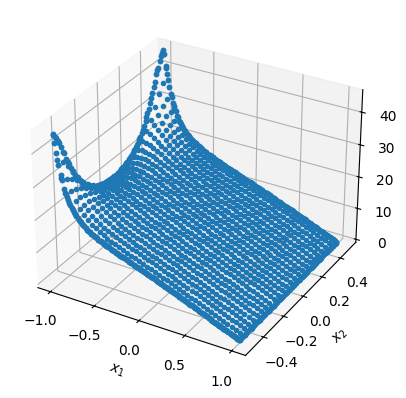

In [60]:
dde.optimizers.config.set_LBFGS_options(maxiter=3000)

model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave = False, isplot = True)

### 3.3.8. Plot Results (Adam + L-BFGS)

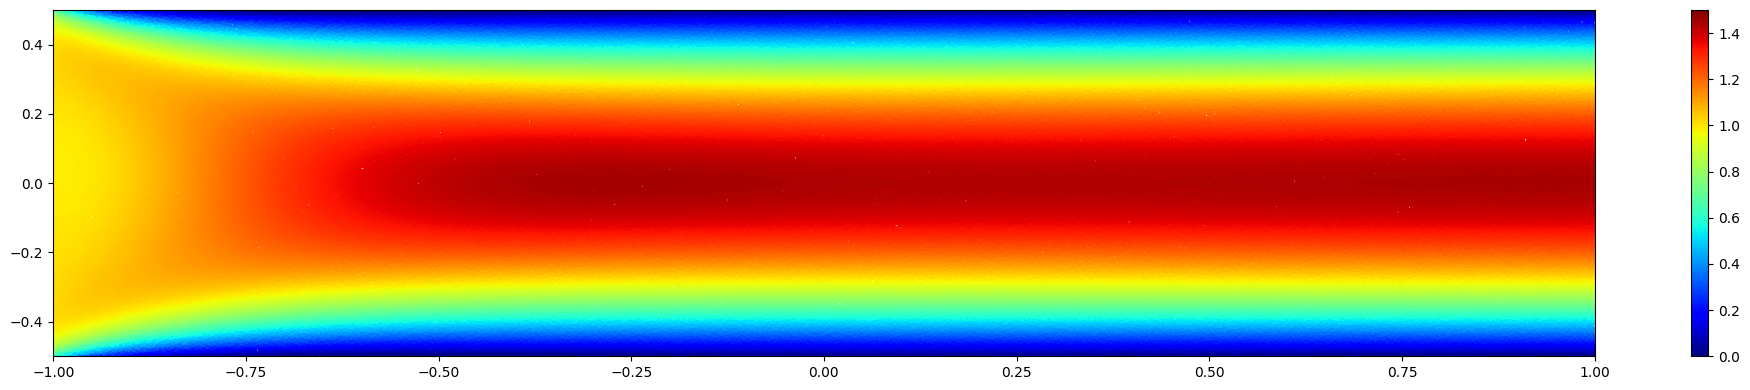

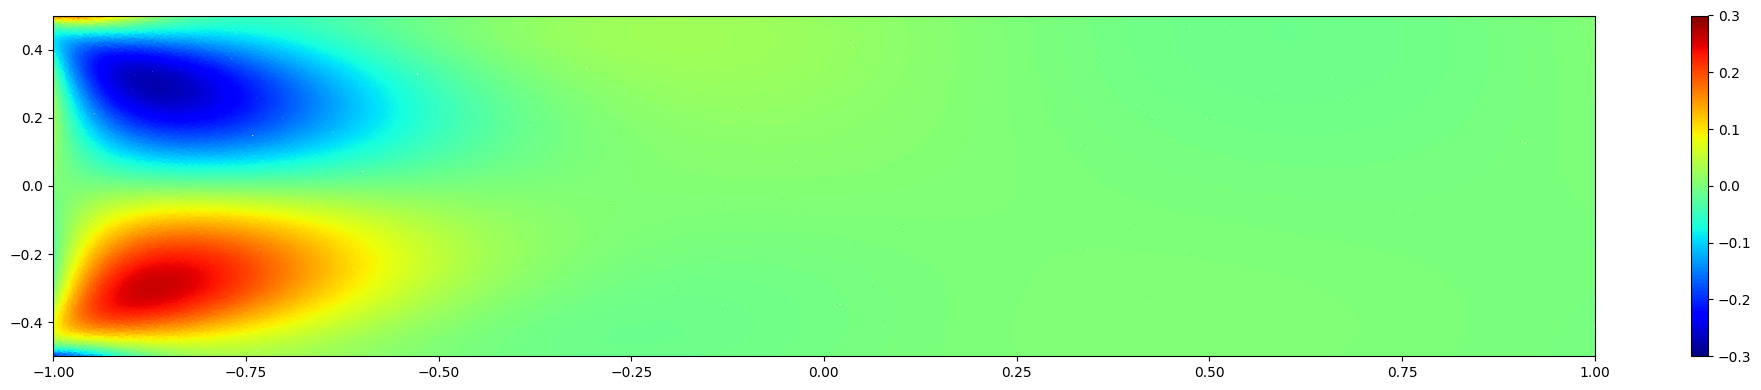

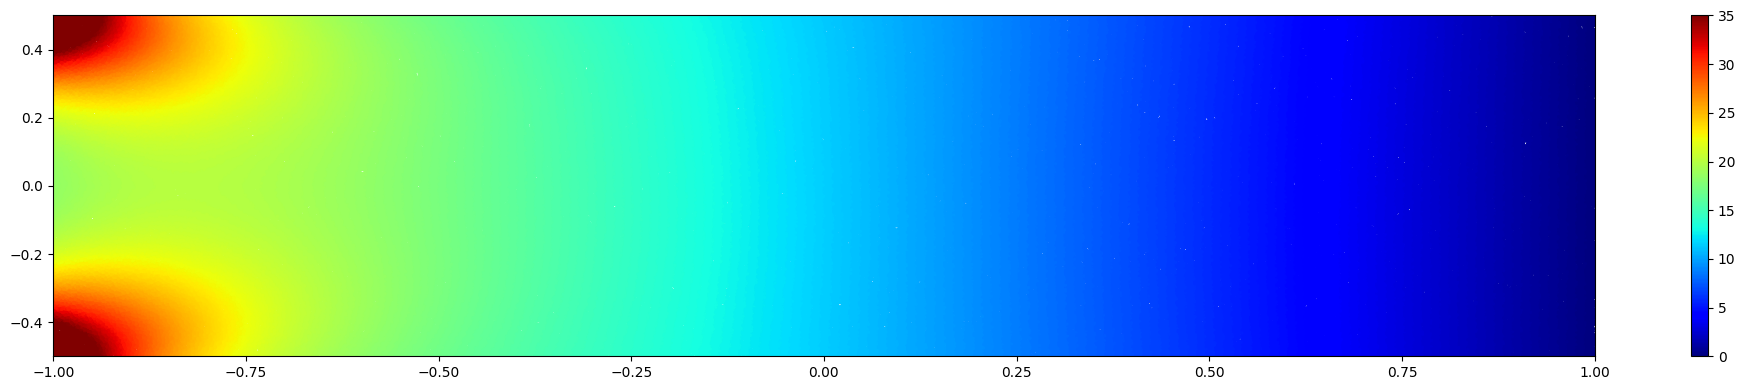

In [61]:
samples = geom.random_points(500000)
result = model.predict(samples)
color_legend = [[0, 1.5], [-0.3, 0.3], [0, 35]]
for idx in range(3):
    plt.figure(figsize = (20, 4))
    plt.scatter(samples[:, 0],
                samples[:, 1],
                c = result[:, idx],
                cmap = 'jet',
                s = 2)
    plt.colorbar()
    plt.clim(color_legend[idx])
    plt.xlim((0-L/2, L-L/2))
    plt.ylim((0-D/2, D-D/2))
    plt.tight_layout()
    plt.show()

### 3.3.9. Validation: Plot Velocity Profile at the End of the Plate
- Fully developed velocity profile at the infinite parallel plates flow are known as

<br>

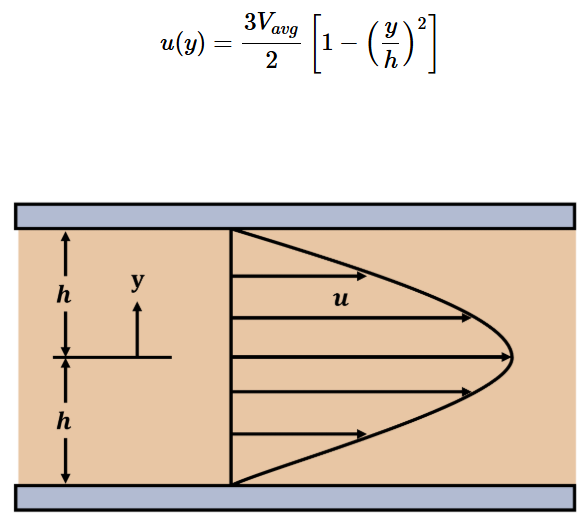

<br>

In [62]:
# Analytic solution
x = np.ones([1000,1])
y = np.linspace(-0.5, 0.5, 1000).reshape(1000,1)
outlet = np.hstack([x, y])

analytic_solution = u_in * 1.5 * (1 - ((y)/(D/2))**2)

PINN_solution = model.predict(outlet)

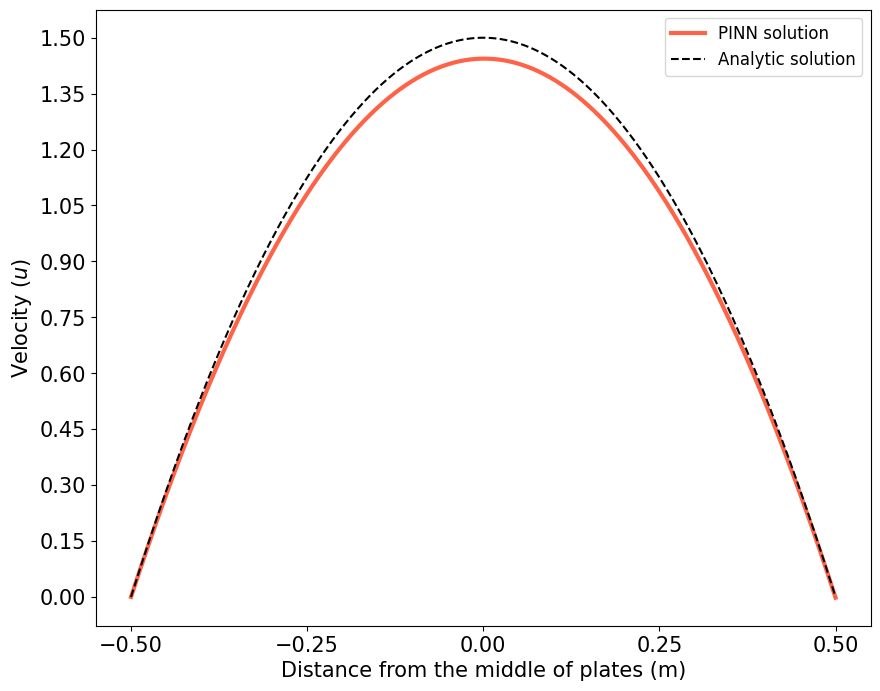

In [63]:
plt.figure(figsize = (10,8))
plt.plot(y, PINN_solution[:, 0], c = 'tomato', linewidth = 3, label = 'PINN solution')
plt.plot(y, analytic_solution, c = 'k', linestyle = '--', label = 'Analytic solution')
plt.xticks(np.linspace(-0.5, 0.5, 5), fontsize = 15)
plt.yticks(np.linspace(0, 1.5, 11), fontsize = 15)
plt.legend(fontsize = 12)
plt.xlabel('Distance from the middle of plates (m)', fontsize = 15)
plt.ylabel('Velocity ($u$)', fontsize = 15)
plt.show()

<br><br><br>
# Lab 4. Inverse Problem: Parameter Estimation

## 4.1 Problem Setup

- Now, we will solve an inverse problem using PINN

<br>
</center>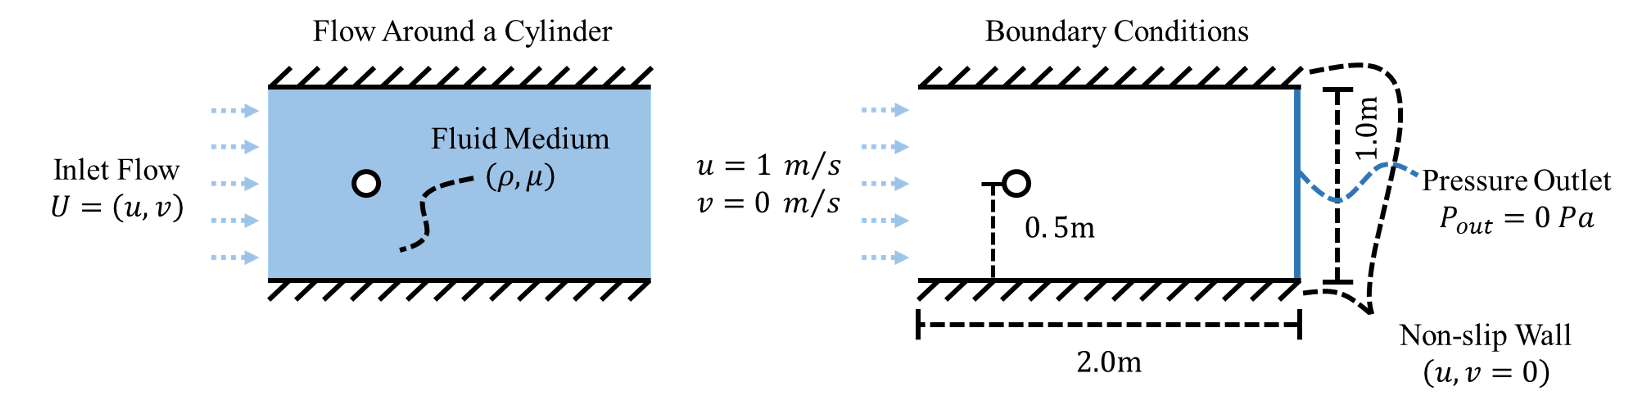

- Problem properties

$$\rho = ? \quad \nu = ?$$
<br>

- Partial differential equations & boundary conditions

<br>
$$
\rho\left(u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} + \frac{1}{\rho}\frac{\partial p}{\partial x}   \right) - \mu\left( \frac{\partial^2u}{\partial^2 x} + \frac{\partial^2u}{\partial^2 y}\right) = 0$$

<br>
$$
\rho\left(u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} + \frac{1}{\rho}\frac{\partial p}{\partial y}   \right) - \mu\left( \frac{\partial^2v}{\partial^2 x} + \frac{\partial^2v}{\partial^2 y}\right) = 0$$

<br>

- Inlet boundary condition ($x=-0.5$):

<br>
$$u|_{x = -0.5} = 1$$

- Outlet boundary condition ($x=1.5$):

<br>
$$v|_{x = 1.5} = 0$$
$$p|_{x = 1.5} = 0$$

- Non-slip boundary condition ($y=\pm 0.5$):

<br>
$$u|_{y = \pm 0.5} = 0$$
$$v|_{y = \pm 0.5} = 0$$


- Make a neural network and loss functions like below :

<center>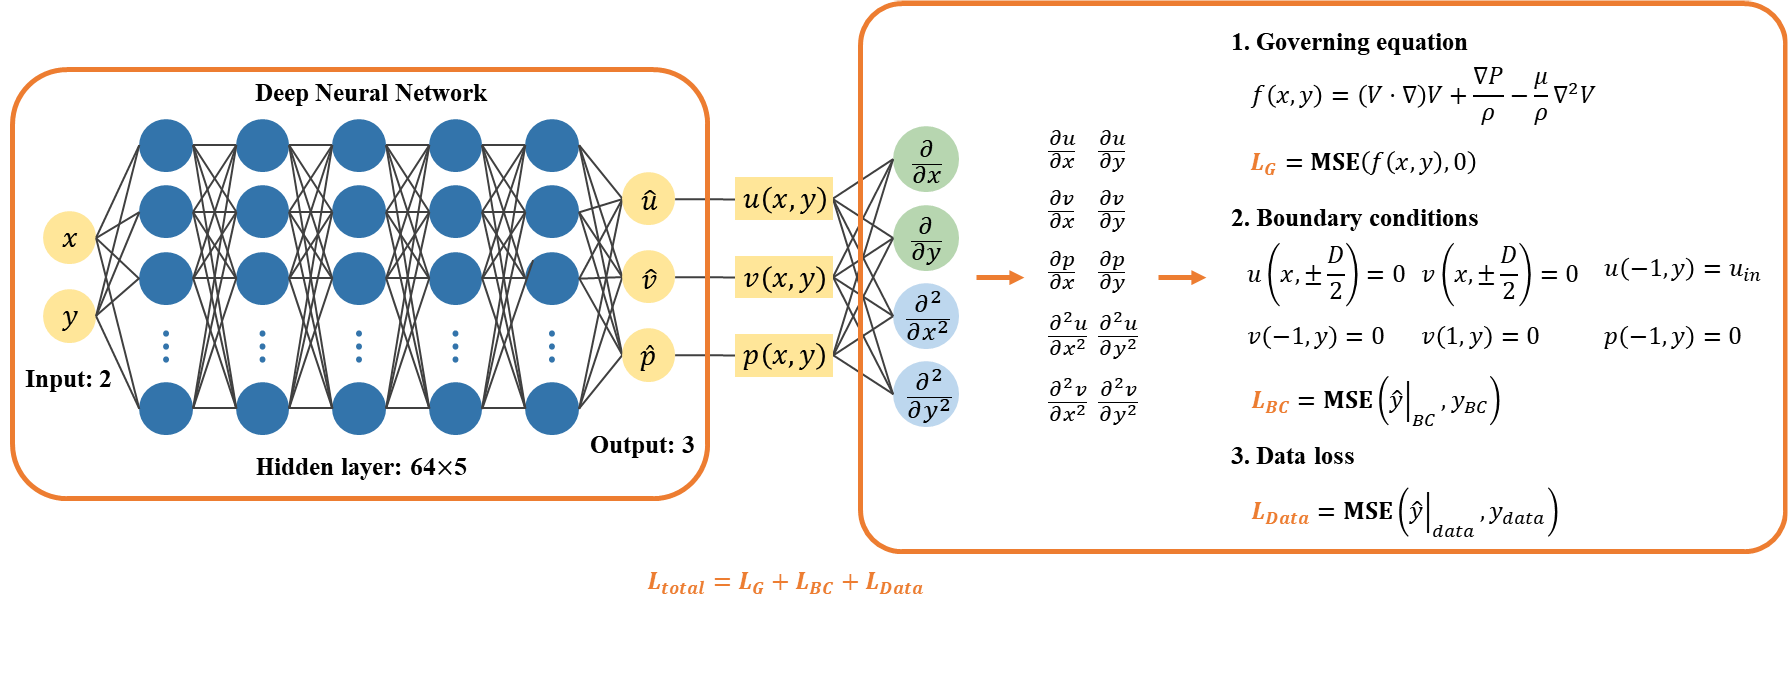

## 4.2 Solve the Inverse Problem

### 4.2.1 Import Library

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# true values
C1true = 1.0
C2true = 0.01

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### 4.2.2 Load the Data

- [lab3_XY_domain](https://www.dropbox.com/scl/fi/7ws4dmqu6gmktoy3zjntt/lab3_XY_domain.npy?rlkey=fvyrvlpw1a0tb3thl94obh7if&st=qtxj7loo&dl=0)
- [lab3_gt_domain](https://www.dropbox.com/scl/fi/3xcyjib52nf6gtrvaytf9/lab3_gt_domain.npy?rlkey=jch4juwnmfdbjwu9d90uwz9zk&st=neuryl1e&dl=0)

In [ ]:
xy_domain= np.load('/content/drive/MyDrive/25_소성_tutorial/lab3_XY_domain.npy')
gt_domain = np.load('/content/drive/MyDrive/25_소성_tutorial/lab3_gt_domain.npy')
print(xy_domain.shape)
print(gt_domain.shape)

(19692, 2)
(19692, 3)


### 4.2.3 Define Collocation Points

In [ ]:
'Boundary Conditions'
bc_top_x = np.linspace(-0.5, 1.5, 200).reshape(-1, 1)
bc_top_y = 0.5 * np.ones_like(bc_top_x).reshape(-1, 1)

bc_bottom_x = np.linspace(-0.5, 1.5, 200).reshape(-1, 1)
bc_bottom_y = -0.5 * np.ones_like(bc_bottom_x).reshape(-1, 1)

bc_inlet_y = np.linspace(-0.5, 0.5, 100).reshape(-1, 1)
bc_inlet_x = -0.5 * np.ones_like(bc_inlet_y).reshape(-1, 1)

bc_outlet_y = np.linspace(-0.5, 0.5, 100).reshape(-1, 1)
bc_outlet_x = 1.5 * np.ones_like(bc_outlet_y).reshape(-1, 1)

xy_top = np.concatenate((bc_top_x, bc_top_y), 1)
xy_bottom = np.concatenate((bc_bottom_x, bc_bottom_y), 1)
xy_inlet = np.concatenate((bc_inlet_x, bc_inlet_y), 1)
xy_outlet = np.concatenate((bc_outlet_x, bc_outlet_y), 1)

radius = 0.05
theta = np.linspace(0, 2 * np.pi, 200)
bc_cylinder_x = (0 + radius * np.cos(theta)).reshape(-1, 1)
bc_cylinder_y = (0 + radius * np.sin(theta)).reshape(-1, 1)
xy_cylinder = np.concatenate((bc_cylinder_x, bc_cylinder_y), 1)

xy_wall = np.concatenate((xy_top, xy_bottom, xy_cylinder))


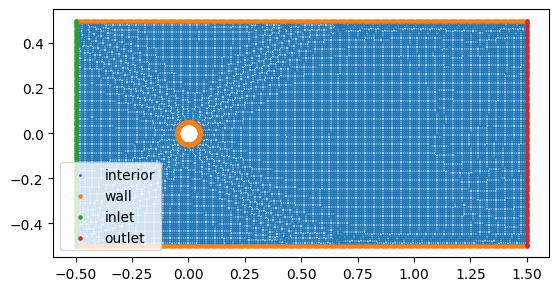

In [ ]:
plt.scatter(xy_domain[:, 0], xy_domain[:, 1], s = 1, label='interior')
plt.scatter(xy_wall[:, 0], xy_wall[:, 1], s = 5, label='wall')
plt.scatter(xy_inlet[:, 0], xy_inlet[:, 1], s = 5, label='inlet')
plt.scatter(xy_outlet[:, 0], xy_outlet[:, 1], s = 5, label='outlet')
plt.axis('scaled')
plt.legend()
plt.show()

### 4.2.4 Define Observation Points
- This CFD data is where the density $\rho$ is 1 and the viscosity $\mu$ is 0.01.

XY obs: (49, 2)
GT obs: (49, 3)


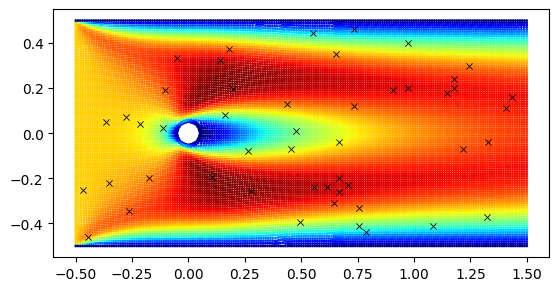

In [ ]:
idx_obs = np.random.choice(len(xy_domain), int(0.0025 * len(xy_domain)), replace=False)
xy_obs = xy_domain[idx_obs]
gt_obs = gt_domain[idx_obs]
print('XY obs: {}'.format(xy_obs.shape))
print('GT obs: {}'.format(gt_obs.shape))

plt.scatter(xy_domain[:, 0], xy_domain[:, 1], c = gt_domain[:, 0], s = 1, cmap = 'jet')
plt.scatter(xy_obs[:, 0], xy_obs[:, 1], marker = 'x', linewidths = 0.6, s = 20, c = 'k')
plt.axis('scaled')
plt.show()

### 4.2.5 Define PINN Network

In [ ]:
import torch.nn as nn
from torch.nn import Linear, Tanh

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
        Linear(2, 256),
        Tanh(),
        Linear(256, 256),
        Tanh(),
        Linear(256, 256),
        Tanh(),
        Linear(256, 256),
        Tanh(),
        Linear(256, 3),
        )

        self._initialize_weights()

    '''
    Xavier initializer (Glorot initialization):
    Initializes the weights to keep the variance consistent across layers,
    preventing issues like vanishing or exploding gradients. Weights are
    drawn from a distribution with variance 2/(fan_in + fan_out).
    Biases are set to zero.
    '''
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.float()
        output = self.net(x)
        u, v, p = output[:, 0:1], output[:, 1:2], output[:, 2:3]
        return u, v, p


### 4.2.6 Define Governing Eqaution and Boundary Conditions

In [ ]:
def derivative(y, t) :
    df = torch.autograd.grad(y, t, grad_outputs = torch.ones_like(y).to(device), create_graph = True)[0]
    df_x = df[:, 0:1]
    df_y = df[:, 1:2]
    return df_x, df_y

def PDE(model, XY_domain):
    u, v, p = model(XY_domain)

    du_x, du_y = derivative(u, XY_domain)
    dv_x, dv_y = derivative(v, XY_domain)
    dp_x, dp_y = derivative(p, XY_domain)

    du_xx, _ = derivative(du_x, XY_domain)
    _, du_yy = derivative(du_y, XY_domain)
    dv_xx, _ = derivative(dv_x, XY_domain)
    _, dv_yy = derivative(dv_y, XY_domain)

    pde_u = rho * (u * du_x + v * du_y) + dp_x - vis * (du_xx + du_yy)
    pde_v = rho * (u * dv_x + v * dv_y) + dp_y - vis * (dv_xx + dv_yy)
    pde_cont = du_x + dv_y
    return pde_u, pde_v, pde_cont

def BC_wall(model, XY_wall):
    u_wall, v_wall, _ = model(XY_wall)
    return u_wall, v_wall

def BC_inlet(model, XY_inlet):
    u_inlet, v_inlet, _ = model(XY_inlet)
    u_inlet = u_inlet - torch.ones_like(u_inlet).to(device)

    return u_inlet, v_inlet

def BC_outlet(model, XY_outlet):
    _, v_outlet, p_outlet = model(XY_outlet)
    return v_outlet, p_outlet

### 4.2.7 Numpy to Tensor

In [ ]:
def require_grad(x):
    return torch.tensor(x, dtype = torch.float32, requires_grad = True).to(device)

XY_domain = require_grad(xy_domain)
XY_wall = require_grad(xy_wall)
XY_inlet = require_grad(xy_inlet)
XY_outlet = require_grad(xy_outlet)
XY_obs = require_grad(xy_obs)
gt_obs = require_grad(gt_obs)

'''
Initialize \rho and \mu as NumPy arrays with the value 1.
'''
rho = torch.ones(1).to(device).requires_grad_(True).float()
vis = torch.ones(1).to(device).requires_grad_(True).float()

model = PINN().to(device)
optimizer = torch.optim.Adam([{'params': model.parameters(), 'lr':1e-4},
                              {'params': rho, 'lr':1e-4},
                              {'params': vis, 'lr':1e-4}])
loss_fn = nn.MSELoss()

### 4.2.8 Train and Save the model

In [ ]:
epochs = 30001
best_loss = float('inf')
loss_list = []
rho_list, vis_list = [], []

for epoch in range(epochs):

    PDE_u, PDE_v, PDE_cont = PDE(model, XY_domain)
    loss_PDE_u = loss_fn(PDE_u, torch.zeros_like(PDE_u))
    loss_PDE_v = loss_fn(PDE_v, torch.zeros_like(PDE_v))
    loss_PDE_cont = loss_fn(PDE_cont, torch.zeros_like(PDE_cont))
    loss_pde = loss_PDE_u + loss_PDE_v + loss_PDE_cont

    u_wall, v_wall = BC_wall(model, XY_wall)
    u_inlet, v_inlet = BC_inlet(model, XY_inlet)
    v_outlet, p_outlet = BC_outlet(model, XY_outlet)

    loss_BC_wall_u = loss_fn(u_wall, torch.zeros_like(u_wall))
    loss_BC_wall_v = loss_fn(v_wall, torch.zeros_like(v_wall))
    loss_BC_inlet_u = loss_fn(u_inlet, torch.zeros_like(u_inlet))
    loss_BC_inlet_v = loss_fn(v_inlet, torch.zeros_like(v_inlet))
    loss_BC_outlet_v = loss_fn(v_outlet, torch.zeros_like(v_outlet))
    loss_BC_outlet_p = loss_fn(p_outlet, torch.zeros_like(p_outlet))
    loss_bc = loss_BC_wall_u + loss_BC_wall_v + loss_BC_inlet_u + loss_BC_inlet_v + loss_BC_outlet_v + loss_BC_outlet_p

    u_obs, v_obs, p_obs = model(XY_obs)
    loss_data_u = loss_fn(u_obs, gt_obs[:, 0:1])
    loss_data_v = loss_fn(v_obs, gt_obs[:, 1:2])
    loss_data_p = loss_fn(p_obs, gt_obs[:, 2:3])
    loss_data = loss_data_u + loss_data_v + loss_data_p

    loss = loss_pde + loss_bc + loss_data

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    rho_list.append(rho.item())
    vis_list.append(vis.item())

    if loss.item() < best_loss:
        best_loss = loss.item()
#         torch.save(model, 'lab3.pt')

    if epoch % 1000 == 0:
        print(f'Epoch: {epoch}, Loss: {loss}')


print('Training Finish')


Epoch: 0, Loss: 7.000944137573242
Epoch: 1000, Loss: 0.8413459658622742
Epoch: 2000, Loss: 0.6318556666374207
Epoch: 3000, Loss: 0.4714846611022949
Epoch: 4000, Loss: 0.3416963517665863
Epoch: 5000, Loss: 0.23687352240085602
Epoch: 6000, Loss: 0.15450696647167206
Epoch: 7000, Loss: 0.09283903986215591
Epoch: 8000, Loss: 0.050019945949316025
Epoch: 9000, Loss: 0.02363850548863411
Epoch: 10000, Loss: 0.010335470549762249
Epoch: 11000, Loss: 0.0056358822621405125
Epoch: 12000, Loss: 0.004766901023685932
Epoch: 13000, Loss: 0.00471544498577714
Epoch: 14000, Loss: 0.004714995622634888
Epoch: 15000, Loss: 0.004714995622634888
Epoch: 16000, Loss: 0.004714995622634888
Epoch: 17000, Loss: 0.0047150771133601665
Epoch: 18000, Loss: 0.004714996088296175
Epoch: 19000, Loss: 0.004714995622634888
Epoch: 20000, Loss: 0.0047149984166026115
Epoch: 21000, Loss: 0.0047152843326330185
Epoch: 22000, Loss: 0.004714995622634888
Epoch: 23000, Loss: 0.004714999347925186
Epoch: 24000, Loss: 0.004714995622634888


### 4.2.9 Result

In [ ]:
def PLOT(model, XY_domain, rho_list, vis_list):
    u, v, p = model(XY_domain)

    plt.figure(figsize = (9, 2))
    plt.subplot(1, 3, 1)
    plt.title('CFD')
    plt.scatter(XY_domain[:, 0].detach().cpu().numpy(), XY_domain[:, 1].detach().cpu().numpy(),
                c = gt_domain[:, 0], s = 0.1, cmap = 'jet')
    plt.axis('scaled')

    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.scatter(XY_domain[:, 0].detach().cpu().numpy(), XY_domain[:, 1].detach().cpu().numpy(),
                c = u.detach().cpu().numpy(), s = 0.1, cmap = 'jet')
    plt.axis('scaled')

    plt.subplot(1, 3, 3)
    plt.title('Error')
    plt.scatter(XY_domain[:, 0].detach().cpu().numpy(), XY_domain[:, 1].detach().cpu().numpy(),
                c = np.abs(u.detach().cpu().numpy() - gt_domain[:, 0:1]), s = 0.1, cmap = 'jet')
    plt.axis('scaled')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize = (6, 2))
    plt.subplot(1, 2, 1)
    plt.title('Rho Prediction')
    plt.plot(rho_list)

    plt.subplot(1, 2, 2)
    plt.title('Vis Prediction')
    plt.plot(vis_list)
    plt.tight_layout()
    plt.show()


#### Load the model parameters
- [lab3.pt](https://www.dropbox.com/scl/fi/ykxhh6987pnlbirhjc4hy/lab3.pt?rlkey=m8cy7tpmbfw5h119uk30hz7on&st=d6hrxw9d&dl=0)

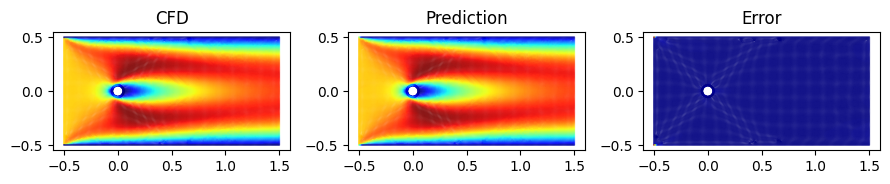

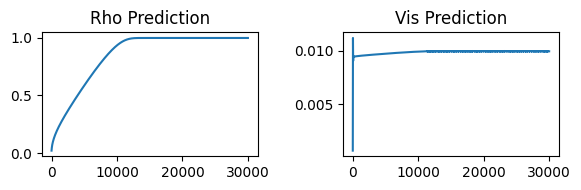

In [ ]:
with torch.no_grad():
    model = torch.load('/content/drive/MyDrive/25_소성_tutorial/lab3.pt', weights_only=False)
    PLOT(model, XY_domain, rho_list, vis_list)



---

